### 1.- We convert the provided coordinates for the Namadgi Park in ACT from UTM into Albers Equal Area projection (Same as the Sentinel and Landsat data)

In [1]:
from pyproj import Proj, transform

inProj = "+proj=utm +zone=55 +south +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"
outProj = Proj(init='epsg:3577')

x1,y1 = (653513,6073754)
x1,y1 = transform(inProj,outProj,x1,y1)
x2,y2 = (709812,6018355)
x2,y2 = transform(inProj,outProj,x2,y2)

/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/env/lib/python3.6/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


### 2.- Select the clearest scene that is closer to the 27th of Jan 2020 -> 21st November used here

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import datacube

dc = datacube.Datacube(app='fmc')

query = {
        'y': (y1,y2),
        'x': (x1,x2),
        'crs': 'EPSG:3577',
        'output_crs': 'EPSG:3577',
        'resolution': (-25, 25),
        'time': ('2019-11-20', '2019-11-22'),
        'measurements': ["nbar_blue","nbar_green","nbar_red",
                         "nbart_red_edge_1","nbart_red_edge_2","nbart_red_edge_3",
                         "nbar_nir_1","nbar_nir_2",
                         "nbar_swir_2","nbar_swir_3"],}

s2_nmdg = dc.load(product='s2a_ard_granule', group_by='solar_day', **query)

s2_nmdg = s2_nmdg.isel(time=0)

(2458, 1988)


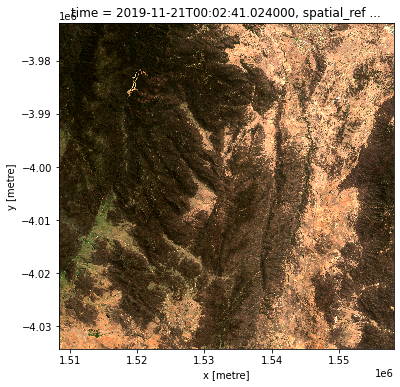

In [3]:
s2_nmdg[['nbar_red', 'nbar_green', 'nbar_blue']].to_array().plot.imshow(robust=True, figsize=(6,6))
print(s2_nmdg['nbar_red'].shape)

### 3.- Create 3-dimensional array with the reflectance values for Namadgi for each spectral bands. NDII is stacked as a new band and NDVI is calculated separately to be used inside the loop.

In [4]:
import numpy as np

refl = s2_nmdg[["nbar_green","nbar_red",
         "nbart_red_edge_1","nbart_red_edge_2","nbart_red_edge_3",
         "nbar_nir_1","nbar_nir_2",
         "nbar_swir_2","nbar_swir_3"]].to_array().values/10000

ndvi=((s2_nmdg.nbar_nir_1-s2_nmdg.nbar_red)/(s2_nmdg.nbar_nir_1-s2_nmdg.nbar_red)).values
ndii=((s2_nmdg.nbar_nir_1-s2_nmdg.nbar_swir_2)/(s2_nmdg.nbar_nir_1-s2_nmdg.nbar_swir_2)).values

refl = np.concatenate([refl,ndii[None,:,:]], axis=0)

refl.shape, ndvi.shape

((10, 2458, 1988), (2458, 1988))

### 4.- Vegetation mask computation using the WCF and VegH products.

(2458, 1988)

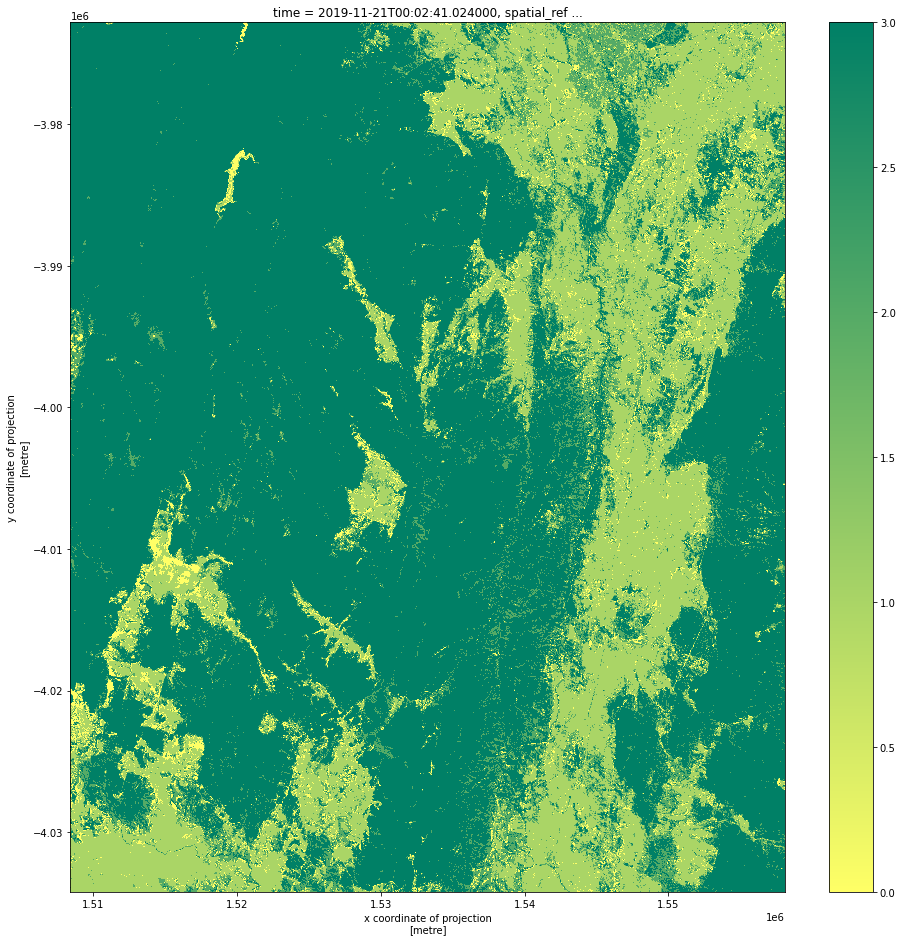

In [5]:
import xarray as xr
import numpy as np

ds = xr.open_dataset("http://dapds00.nci.org.au/thredds/dodsC/ub8/au/LandCover/OzWALD_LC/VegH_2007-2010_mosaic_AustAlb_25m.nc")
vegh = ds.VegH.sel(x=s2_nmdg.x, y=s2_nmdg.y)

ds = xr.open_dataset("http://dapds00.nci.org.au/thredds/dodsC/ub8/au/LandCover/OzWALD_LC/WCF_2018_mosaic_AustAlb_25m.nc#fillmismatch")
wcf = ds.WCF.sel(x=s2_nmdg.x, y=s2_nmdg.y)

"""
grass = (wcf<10)*(vegh<2)*(vegh!=0)*1
shrub = (wcf>=10)*(vegh<2)*(vegh!=0)*2
sav_2 = (wcf>=10)*(wcf<20)*(vegh>=2)*3
sav_1 = (wcf>=20)*(wcf<30)*(vegh>=2)*4
forest = (wcf>=30)*(vegh>=2)*5
"""

# Original classes with savanah merged into shrub
grass = (wcf<10)*(vegh<2)*(vegh!=0)*1
shrub = (wcf>=10)*(vegh<2)*(vegh!=0)*2
sav_2 = (wcf>=10)*(wcf<20)*(vegh>=2)*2
sav_1 = (wcf>=20)*(wcf<30)*(vegh>=2)*2
forest = (wcf>=30)*(vegh>=2)*3

mask = shrub+grass+sav_1+sav_2+forest

mask.transpose().plot(figsize=(10,10),cmap='summer_r')

mask = mask.values.T

mask.shape

### 5.- Read LUT, clean extra columns and compute NDII

In [6]:
import pandas as pd

df = pd.read_csv("LUT_S2.csv", index_col='ID')
#NDII=nbar_nir_1-nbar_swir_2/nbar_nir_1+nbar_swir_2
df = df.drop(columns=['lai','soil','n','443','490','1375','945'])
df.columns = ['fmc','landcover','green','red','red_edge1','red_edge2','red_edge3','nir1','nir2','swir2','swir3']
df[df.landcover=='forest'].shape, df[df.landcover=='shrub'].shape, df[df.landcover=='grass'].shape
df['ndii'] = (df['nir1']-df['swir2'])/(df['nir1']+df['swir2'])
df

,fmc,landcover,green,red,red_edge1,red_edge2,red_edge3,nir1,nir2,swir2,swir3,ndii
ID,,,,,,,,,,,,
1,20.833333,forest,0.076868,0.087759,0.121440,0.20231,0.24001,0.25976,0.26846,0.300440,0.208560,-0.072617
2,20.833333,forest,0.063906,0.067180,0.099146,0.20084,0.24649,0.26449,0.27273,0.272630,0.169290,-0.015155
3,20.833333,forest,0.052958,0.049173,0.080043,0.20238,0.25585,0.27231,0.28016,0.249960,0.135210,0.042794
4,20.833333,forest,0.045717,0.035899,0.066817,0.20949,0.27051,0.28579,0.29338,0.236750,0.110690,0.093849
5,20.833333,forest,0.078798,0.090601,0.124790,0.20314,0.23922,0.25933,0.26813,0.306360,0.214890,-0.083137
...,...,...,...,...,...,...,...,...,...,...,...,...
8725,135.678392,shrub,0.036880,0.021712,0.050855,0.20334,0.26159,0.27293,0.27922,0.102840,0.035020,0.452644
8726,135.678392,shrub,0.036516,0.021083,0.050138,0.20460,0.26418,0.27550,0.28182,0.100780,0.033282,0.464335
8727,135.678392,shrub,0.036199,0.020537,0.049509,0.20578,0.26662,0.27792,0.28428,0.098948,0.031758,0.474893


#### Correspondance wavelength -> band name
```
560: 'green'
665: 'red'
705: 'red_edge_1'
740: 'red_edge_2'
783: 'red_edge_3'
842: 'nir1'
865: 'nir2'
1610: 'swir2'
2190: 'swir3'
```

### 6.- Loop for computing FMC values for Namadgi

In [ ]:
import time

start = time.time()

canvas = np.ones(mask.shape, dtype=np.float32) * np.nan
top_n = 40

lut_map = {1: df[df.landcover=='grass'][['fmc','green','red','red_edge1','red_edge2','red_edge3','nir1','nir2','swir2','swir3','ndii']].values,
           2: df[df.landcover=='shrub'][['fmc','green','red','red_edge1','red_edge2','red_edge3','nir1','nir2','swir2','swir3','ndii']].values,
           3: df[df.landcover=='forest'][['fmc','green','red','red_edge1','red_edge2','red_edge3','nir1','nir2','swir2','swir3','ndii']].values,}

# Add the squares of the LUT entries to speed up calculation inside loop
lut_map[4] = np.einsum('ij,ij->i',lut_map[1][:,1:], lut_map[1][:,1:])**.5
lut_map[5] = np.einsum('ij,ij->i',lut_map[2][:,1:], lut_map[2][:,1:])**.5
lut_map[6] = np.einsum('ij,ij->i',lut_map[3][:,1:], lut_map[3][:,1:])**.5


for j in range(mask.shape[0]):
        
    for i in range(mask.shape[1]):
        x = refl[:,j,i]
        m = mask[j,i]
        
        if m == 0 or ndvi[j,i]<.15:
            continue

        θ = -1*(np.einsum('ij,j->i', lut_map[m][:,1:], x)/(np.einsum('i,i->', x, x)**.5*lut_map[m+3]))
   
        idxs = np.argpartition(θ, top_n)[:top_n]
        canvas[j,i] = np.median(lut_map[m][idxs,0])
        
print(time.time() - start)

0
100
200
300
400
500
600
700
800
900
1000
1100


### 7.- FMC map for Namadgi

243.1001


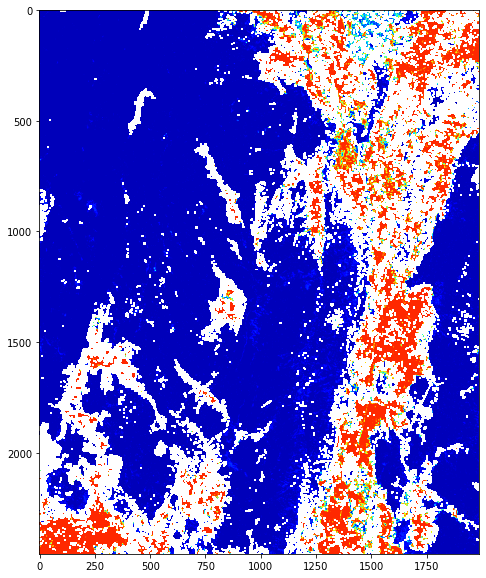

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(canvas, cmap='jet')
print(canvas[0,-1])

### 7.- Histogram of FMC values

243.1001


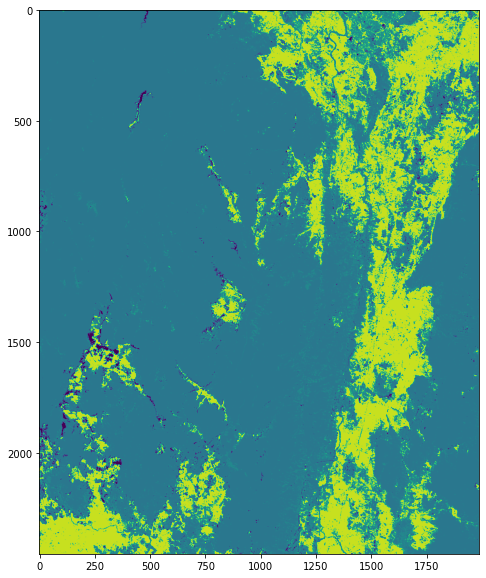

In [10]:
_ = plt.histogram(canvas)